In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Passo 1: Leitura dos dados
Leitura dos bancos de dados em DataFrame Pandas. 

In [131]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_lazaro.csv'

In [132]:
df = pd.read_csv(caminho_dados_lazaro)

In [133]:
df.head()

,Piquete,Altura real,Altura esperada,Animal,SensorID,Sensor Name,Date,X,Y,Z,Comportamento,Season
0,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:30,-0.012,-0.456,0.900,Indefinido,Indefinido
1,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:32,-0.008,-0.456,0.892,Indefinido,Indefinido
2,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:33,-0.010,-0.460,0.897,Indefinido,Indefinido
3,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:33,0.021,-0.386,0.963,Indefinido,Indefinido
4,11,25.2,25.0,85,434138,Accelerometer - 434138,2019-11-09 08:25:34,0.012,-0.423,0.910,Indefinido,Indefinido


## Passo 2: Pré-processamento


In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Função para calcular acuracia de cada etapa do Pré-processamento
def calc_acuracia(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    print("Acurácia da etapa:")
    print(accuracy_score(y_valid, preds)*100)

### 2.0 Seleção de colunas aplicáveis

In [135]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season'],
      dtype='object')

In [136]:
# Lista com os atributos aplicáveis
features_aplicaveis = ['X', 'Y', 'Z', 'Comportamento', 'Season']

# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

### 2.1 Lidando com dados faltantes

In [137]:
df[df.isnull().any(axis=1)]

,X,Y,Z,Comportamento,Season
296,175786.0,NaN,NaN,Indefinido,Indefinido


In [138]:
df.isnull().sum()

X                0
Y                1
Z                1
Comportamento    0
Season           0
dtype: int64

In [139]:
# No entanto, durante a integração dos dados valores nulos em "Comportamento" e "Season" foram nomeados "Indefinido", logo temos que tratá-los
df.Comportamento.value_counts()

Pastejando     342516
Ruminando      158228
Ocio           126141
Indefinido      23496
Outros          19472
Locomovendo     12567
Agua             3779
Outro            2303
Ócio             2064
Name: Comportamento, dtype: int64

In [140]:
df = df.replace('Indefinido', np.NaN)

In [141]:
# Como praticamente não há valores faltantes nas variáveis independentes e há obeservações com variáveis alvo nulas, o melhor é apenas eliminar linhas com valores nulos
df = df.dropna(axis=0)
df.isnull().sum()

X                0
Y                0
Z                0
Comportamento    0
Season           0
dtype: int64

### 2.2 Tratamento de dados categóricos

#### Correção dos nomes das classificações

In [142]:
np.unique(df['Comportamento'])

array(['Agua', 'Locomovendo', 'Ocio', 'Outro', 'Outros', 'Pastejando',
       'Ruminando', 'Ócio'], dtype=object)

In [143]:
df = df.replace(to_replace=['Ócio','Outro'], value=['Ocio', 'Outros'])

In [144]:
np.unique(df['Season'])

array(['Spring', 'fall', 'spring', 'spring ', 'summer'], dtype=object)

In [145]:
df = df.replace(to_replace=['Spring','spring '], value=['spring', 'spring'])

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [146]:
X = df[['X', 'Y', 'Z', 'Season']]
y = df.Comportamento

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

#### Codificação - Usando One-Hot Encoding

In [147]:
from sklearn.preprocessing import OneHotEncoder

# Aplica one-hot encoder à coluna Season
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train['Season'].values.reshape(-1,1)))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid['Season'].values.reshape(-1,1)))

In [148]:
# One-hot encoder remove os indices; recuperando-os
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

In [149]:
# Remoção da coluna Season (será substituida com one-hot encoding)
num_X_train = X_train.drop('Season', axis=1)
num_X_valid = X_valid.drop('Season', axis=1)

In [150]:
# Adiciona colunas codificadas por one-hot a features numéricas
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [151]:
# Get_dummies é suficente
# X = df[['X', 'Y', 'Z', 'Season']]
# X = pd.get_dummies(X)

In [152]:
X = df[['X', 'Y', 'Z', 'Season']]
y = df.Comportamento

# Test size = 0.25
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

# Como one-hot encoder foi melhor, usaremos ele
X_train = OH_X_train
X_valid = OH_X_valid

### 2.3 Tratamento de outliers

In [27]:
X_train.describe()

,X,Y,Z,0,1,2
count,500302.000000,500302.000000,500302.000000,500302.000000,500302.000000,500302.000000
mean,0.003847,0.076661,0.301881,0.397132,0.244940,0.357928
std,0.576718,0.580535,0.496833,0.489304,0.430052,0.479391
min,-1.999000,-2.688000,-1.999000,0.000000,0.000000,0.000000
25%,-0.495000,-0.391000,-0.020000,0.000000,0.000000,0.000000
50%,0.018000,0.137000,0.407000,0.000000,0.000000,0.000000
75%,0.475000,0.541000,0.687000,1.000000,0.000000,1.000000
max,2.106000,2.000000,2.020000,1.000000,1.000000,1.000000


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid", palette="rainbow")
%matplotlib inline

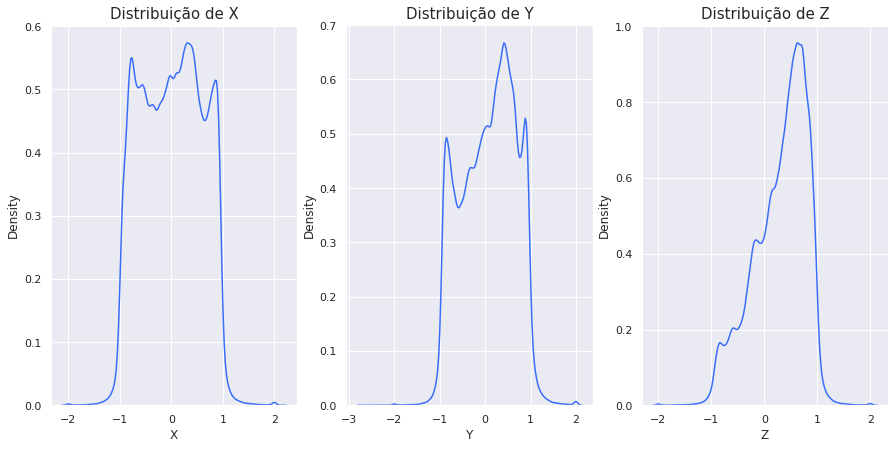

In [69]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.title("Distribuição de X", fontsize=15)
sns.kdeplot(data = df["X"])
plt.subplot(1,3,2)
plt.title("Distribuição de Y", fontsize=15)
sns.kdeplot(data = df["Y"])
plt.subplot(1,3,3)
plt.title("Distribuição de Z", fontsize=15)
sns.kdeplot(data = df["Z"])
plt.show()

#### Inter-Quartile Range (IQR)

In [25]:
q1 = X_train.X.quantile(0.25)
q3 = X_train.X.quantile(0.75)

IQR = q3 - q1

max_limit = q3 + (1.5 * IQR)
min_limit = q1 - (1.5 * IQR) 

In [28]:
X_trainde passa do limite inserir o limite
X_train.X = pd.DataFrame(np.where(X_train.X > max_limit, max_limit, 
         (np.where(X_train.X < min_limit, min_limit, X_train.X))), columns=["X"])

#### Usando Isolation Forest

In [70]:
X_train.describe()

,X,Y,Z,0,1,2
count,500302.000000,500302.000000,500302.000000,500302.000000,500302.000000,500302.000000
mean,0.003847,0.076661,0.301881,0.397132,0.244940,0.357928
std,0.576718,0.580535,0.496833,0.489304,0.430052,0.479391
min,-1.999000,-2.688000,-1.999000,0.000000,0.000000,0.000000
25%,-0.495000,-0.391000,-0.020000,0.000000,0.000000,0.000000
50%,0.018000,0.137000,0.407000,0.000000,0.000000,0.000000
75%,0.475000,0.541000,0.687000,1.000000,0.000000,1.000000
max,2.106000,2.000000,2.020000,1.000000,1.000000,1.000000


In [72]:
X_train_array, y_train_array = X_train.values, y_train.values

In [73]:
print(X_train_array.shape, y_train_array.shape)

(500302, 6) (500302,)


In [74]:
from sklearn.ensemble import IsolationForest
# Identifica outliers no dataset de treino
iso = IsolationForest(contamination=0.1)
result = iso.fit_predict(X_train_array)

In [75]:
# Remove todas as linhas que têm outliers
mask = result != -1
X_train_array, y_train_array = X_train_array[mask, :], y_train_array[mask]
print(X_train_array.shape, y_train_array.shape)

(450273, 6) (450273,)


In [76]:
X_train_array

array([[ 0.804,  0.328,  0.264,  0.   ,  0.   ,  1.   ],
       [-0.536, -0.05 ,  0.832,  1.   ,  0.   ,  0.   ],
       [ 0.911, -0.38 ,  0.077,  0.   ,  1.   ,  0.   ],
       ...,
       [ 0.092,  0.082,  0.963,  0.   ,  1.   ,  0.   ],
       [-0.197, -0.829,  0.809,  1.   ,  0.   ,  0.   ],
       [ 0.715,  0.549, -0.379,  0.   ,  0.   ,  1.   ]])

In [31]:
cols_name = X_train.columns

In [32]:
cols_name

Index(['X', 'Y', 'Z', 0, 1, 2], dtype='object')

In [33]:
X_train = pd.DataFrame(X_train_array, columns=cols_name)

In [34]:
X_train.describe()

,X,Y,Z,0,1,2
count,450271.000000,450271.000000,450271.000000,450271.000000,450271.000000,450271.000000
mean,0.019052,0.087966,0.358427,0.409185,0.210353,0.380462
std,0.568637,0.562688,0.439900,0.491684,0.407560,0.485501
min,-1.999000,-1.999000,-0.986000,0.000000,0.000000,0.000000
25%,-0.481000,-0.365000,0.076000,0.000000,0.000000,0.000000
50%,0.049000,0.157000,0.449000,0.000000,0.000000,0.000000
75%,0.489000,0.542000,0.700000,1.000000,0.000000,1.000000
max,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [44]:
y_train = pd.Series(y_train_array)

In [45]:
calc_acuracia(X_train, X_valid, y_train, y_valid)

Acurácio da etapa:
67.61668905305575


#### Usando quartis

In [84]:
df_train = X_train.merge(y_train, left_index=True, right_index=True)

In [85]:
# Calculo de limites para definição de outliers
# Seleciona dados que estão e 1% e 99% do dados
min = 0.01
max = 0.99
X_min_thresold, X_max_thresold = df_train.X.quantile([min, max])
Y_min_thresold, Y_max_thresold = df_train.Y.quantile([min, max])
Z_min_thresold, Z_max_thresold = df_train.Z.quantile([min, max])


In [86]:
# Remoção de outliers em X
df_train = df_train[(df_train.X<X_max_thresold) & (df_train.X>X_min_thresold)]
df_train = df_train[(df_train.Y<Y_max_thresold) & (df_train.Y>Y_min_thresold)]
df_train = df_train[(df_train.Z<Z_max_thresold) & (df_train.Z>Z_min_thresold)]
df_train.shape


(472035, 7)

In [87]:
y_train

328177    Pastejando
532835          Ocio
23970           Ocio
337582    Pastejando
101243    Pastejando
             ...    
365749    Pastejando
158281          Ocio
123465    Pastejando
441795    Pastejando
311677     Ruminando
Name: Comportamento, Length: 500302, dtype: object

In [94]:
y_train = df_train.Comportamento
df_train.drop('Comportamento', axis=1, inplace=True)
X_train = df_train

In [95]:
calc_acuracia(X_train, X_valid, y_train, y_valid)

Acurácio da etapa:
68.62347692602897


### 2.4 Transformação

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.transform(X_valid)
calc_acuracia(X_train, X_valid, y_train, y_valid)

## Passo 3: Treinamento

In [153]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

In [154]:
# Importa o Halving Grid Search para a busca do melhores hiperparêmetros
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV 

In [155]:
# Conjunto com todas as classes
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

In [26]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_valid, y_train, y_valid = train_test_split(X, y_pnp, random_state = 0)

In [77]:
# 4.2 – Conjunto de dados PRO: Pastejando x Ruminando x Ócio
y_pro = y
y_pro = y_pro.replace(to_replace=['Agua', 'Locomovendo', 'Outros'], value='Ocio')
X_train, X_valid, y_train, y_valid = train_test_split(X, y_pro, random_state = 0)

### Função para imprimir e salvar matriz de confusão

In [161]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_valid, preds, model):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    titles_options = [
        ("Matriz de confusão, sem normalização", None),
        ("Matriz de confusão normalizada por predição", "pred"),
    ]
    for title, normalize in titles_options:
        cm = confusion_matrix(y_valid, preds, normalize=normalize)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        if normalize == None:
            disp.plot(xticks_rotation=60)
        else:
            disp.plot(values_format= '.0%', xticks_rotation=60)
        disp.ax_.set_title(title)
    plt.savefig('matrizConfusaoRandomForest.png')
    plt.show()

### Random Forest

#### Com Randomized Search CV

In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0, train_size=0.20)

In [97]:
X_train.shape

(133414, 6)

In [98]:
rf_Model = RandomForestClassifier(random_state=0)

In [99]:
# Create the param grid
param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [100]:
from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 3, verbose=1, n_jobs = 4)

In [101]:
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 55.7 s, sys: 99.8 ms, total: 55.8 s
Wall time: 4min 24s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [50, 100, 150, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10, 30, 50],
                                        'n_estimators': array([ 50, 100, 150, 200])},
                   verbose=1)

In [102]:
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 150,
 'criterion': 'entropy',
 'bootstrap': False}

In [103]:
rf_RandomGrid.best_score_

0.6681008077436279

In [104]:
preds_rf_RG = rf_RandomGrid.predict(X_valid)

In [105]:
accuracy_score(y_valid, preds_rf_RG)*100

67.2352601675986

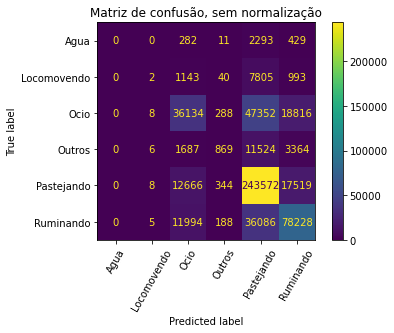

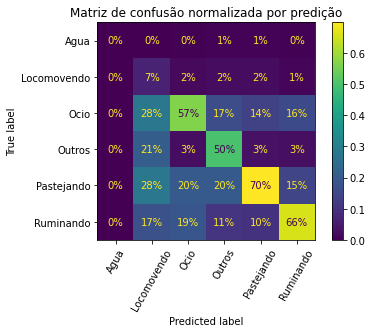

In [106]:
imprimeMatrizDeConfusão(y_valid, preds_rf_RG, rf_RandomGrid)

#### Sem Randomized Search CV

In [91]:
model = RandomForestClassifier(n_estimators=150, random_state=0, n_jobs=4)
model.fit(X_train, y_train)
preds = model.predict(X_valid)

In [92]:
accuracy_score(y_valid, preds)*100

67.32726700346291

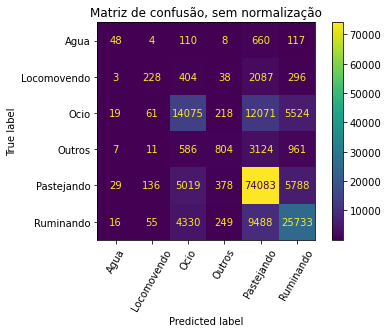

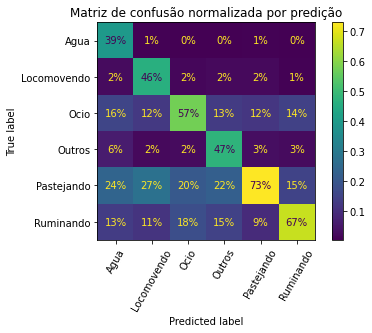

In [ ]:
imprimeMatrizDeConfusão(y_valid, preds, model)

### Gradient Boosting

In [42]:
from xgboost import XGBClassifier

y_train_ordinal = ordinal_encoder.fit_transform(y_train.array.reshape(-1,1))

xgb_cl = XGBClassifier(use_label_encoder=False, random_state=0)
xgb_cl.fit(X_train, y_train_ordinal)

[11:04:30] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [59]:
preds_2 = xgb_cl.predict(X_valid)
preds_2 = ordinal_encoder.inverse_transform(preds_2.reshape(-1,1))
accuracy_score(y_valid, preds_2)

0.6516058236592152

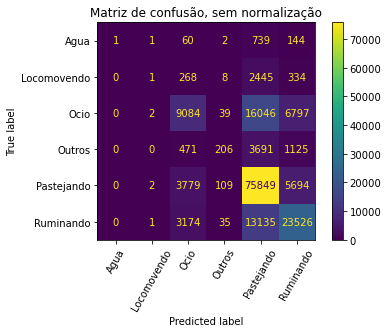

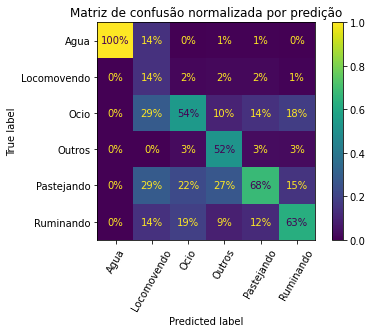

In [60]:
imprimeMatrizDeConfusão(y_valid, preds_2, xgb_cl)

### SVM

In [54]:
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.05, random_state = 0)

In [55]:
%%time
from sklearn.svm import SVC
clf = SVC(kernel='linear', cache_size=5000) # Linear Kernel

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

CPU times: user 8min 8s, sys: 576 ms, total: 8min 9s
Wall time: 8min 9s


In [58]:
print("Acurácia:", accuracy_score(y_valid, y_pred))

Acurácia: 0.6095638905063301


###  Gaussian Naive Bayes

In [158]:
# Conjunto com todas as classes
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 0)

In [159]:
from sklearn.naive_bayes import GaussianNB

In [160]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_valid)
print("Acurácia:", accuracy_score(y_valid, y_pred))

Acurácia: 0.4958924973616041


### Logistic Regression

In [121]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y_pnp = y
y_pnp = y_pnp.replace(to_replace=['Agua', 'Locomovendo', 'Ocio', 'Outros','Ruminando'], value='Não Pastejando')
X_train, X_valid, y_train, y_valid = train_test_split(X, y_pnp, random_state = 0)

In [109]:
from sklearn.linear_model import LogisticRegression

In [123]:
logisticRegr = LogisticRegression(random_state=0)
logisticRegr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [124]:
preds_lr = logisticRegr.predict(X_valid)

In [125]:
print("Acurácia:", accuracy_score(y_valid, preds_lr))

Acurácia: 0.6156936582557805


### Teste em CV

In [213]:
from sklearn.model_selection import cross_val_score

def get_score(n_estimators):
    clf = RandomForestClassifier(n_estimators, random_state=0)
    
    scores = cross_val_score(clf, X, y, cv=3)
    return scores.mean()


In [214]:
results = {} 
n_estimators = 0
while n_estimators < 150:
    n_estimators += 50
    results[n_estimators] = get_score(n_estimators)

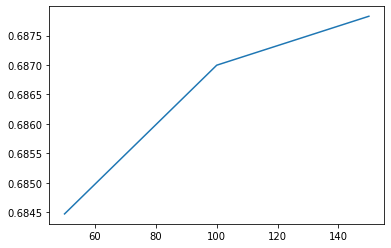

In [215]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()